
# Student Performance: Predição da Nota Final (G3)

**Curso/Disciplina:** Data Mining e Inferência Estatística  
**Autores:** Joao Alexandre)  
**Data:** (09/08/2025)

## Objetivo
Explorar o dataset **Student Performance** (UCI ML Repository) e resolver dois problemas:
1. **Regressão:** prever a nota final `G3` (0–20).
2. **Classificação:** prever **Aprovação** (`passou` = 1 se `G3 >= 10`, caso contrário 0).

## Justificativa
O problema é relevante para identificar fatores associados ao desempenho estudantil e apoiar intervenções pedagógicas precoces.

## Fonte do Dataset
- UCI Machine Learning Repository – *Student Performance* (Matemática/Português).  
  > Por padrão, o notebook baixa e utiliza `student-mat.csv`. Você pode trocar para `student-por.csv`.



# Projeto Final — Student Performance (UCI)
**Objetivo:** EDA + Modelos (Regressão e Classificação) com comparação de métricas.  
**Bases esperadas:** `student-mat.csv` e/ou `student-por.csv` (separador `;`).

> **Como usar:** Coloque os CSVs **na mesma pasta deste notebook**. Se não encontrar, o código tenta um caminho Windows que informei, por fim, tenta baixar do UCI.
https://archive.ics.uci.edu/dataset/320/student+performance

## 1) Setup e Carregamento com Auto-Detecção

In [ ]:
import os, zipfile, urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Habilitar inline
get_ipython().run_line_magic('matplotlib', 'inline')

# 1) Tenta localizar na mesma pasta do notebook
LOCAL_DIR = os.getcwd()
CANDIDATES = [
    os.path.join(LOCAL_DIR, "student-mat.csv"),
    os.path.join(LOCAL_DIR, "student-por.csv"),
]

# 2) Tenta usar o caminho Windows informado
WIN_DIR = r"C:\Users\User\Desktop\MBA_UNIESP_24\Machine learning - Messias_julho_25\PROJEETO FINAL"
CANDIDATES += [
    os.path.join(WIN_DIR, "student-mat.csv"),
    os.path.join(WIN_DIR, "student-por.csv"),
]

def ensure_files():
    """Se nenhum CSV for encontrado, tenta baixar o ZIP oficial do UCI e extrair para a pasta atual."""
    exists = [p for p in CANDIDATES if os.path.exists(p)]
    if exists:
        return exists
    # fallback: tentar baixar do UCI
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip" # Updated URL
    zip_path = os.path.join(LOCAL_DIR, "student.zip")
    try:
        print("Baixando dataset do UCI...")
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(LOCAL_DIR)
        # após extrair, tente achar novamente
        new_candidates = [
            os.path.join(LOCAL_DIR, "student-mat.csv"),
            os.path.join(LOCAL_DIR, "student-por.csv"),
        ]
        return [p for p in new_candidates if os.path.exists(p)]
    except Exception as e:
        print("Falha ao baixar do UCI:", e)
        return []

found = ensure_files()
print("Arquivos encontrados:", found)

# Seleção flexível: USE = "mat" | "por" | "merge"
USE = "mat"

def load_data(USE):
    # mapeia arquivo por tipo
    files = {
        "mat": None,
        "por": None
    }
    for p in found:
        if "student-mat.csv" in os.path.basename(p).lower():
            files["mat"] = p
        if "student-por.csv" in os.path.basename(p).lower():
            files["por"] = p

    if USE == "mat":
        assert files["mat"] is not None, "student-mat.csv não encontrado. Coloque o arquivo na mesma pasta do notebook."
        return pd.read_csv(files["mat"], sep=';'), "Matemática"
    elif USE == "por":
        assert files["por"] is not None, "student-por.csv não encontrado. Coloque o arquivo na mesma pasta do notebook."
        return pd.read_csv(files["por"], sep=';'), "Português"
    elif USE == "merge":
        assert files["mat"] is not None and files["por"] is not None, "Para 'merge' é preciso ter ambos os arquivos na pasta."
        d1 = pd.read_csv(files["mat"], sep=';')
        d2 = pd.read_csv(files["por"], sep=';')
        keys = ["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]
        df = pd.merge(d1, d2, on=keys, suffixes=("_mat","_por"))
        if {"G3_mat","G3_por"}.issubset(df.columns):
            df["G3_avg"] = df[["G3_mat","G3_por"]].mean(axis=1)
        return df, "Merge (Mat + Por)"
    else:
        raise ValueError("USE inválido. Use 'mat', 'por' ou 'merge'.")

df, base_label = load_data(USE)
print(f"Base: {base_label} | Shape: {df.shape}")
df.head()

Baixando dataset do UCI...
Arquivos encontrados: ['/content/student-mat.csv', '/content/student-por.csv']
Base: Matemática | Shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## 2) EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

None

,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


Categóricas: 17
Numéricas  : 16


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
school,395,2,GP,349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,395,2,F,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,395.0,NaN,NaN,NaN,16.696203,1.276043,15.0,16.0,17.0,18.0,22.0
address,395,2,U,307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famsize,395,2,GT3,281,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pstatus,395,2,T,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medu,395.0,NaN,NaN,NaN,2.749367,1.094735,0.0,2.0,3.0,4.0,4.0
Fedu,395.0,NaN,NaN,NaN,2.521519,1.088201,0.0,2.0,2.0,3.0,4.0
Mjob,395,5,other,141,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fjob,395,5,other,217,NaN,NaN,NaN,NaN,NaN,NaN,NaN


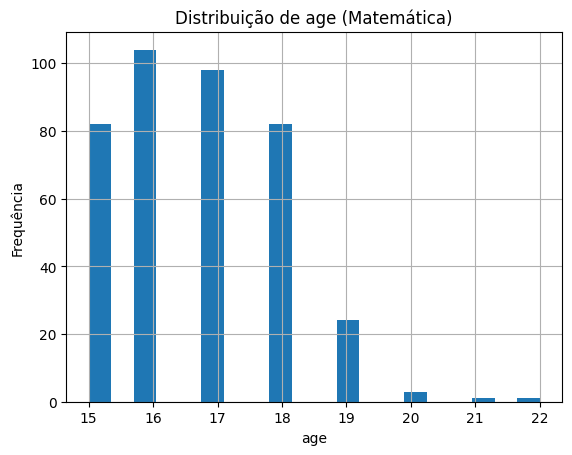

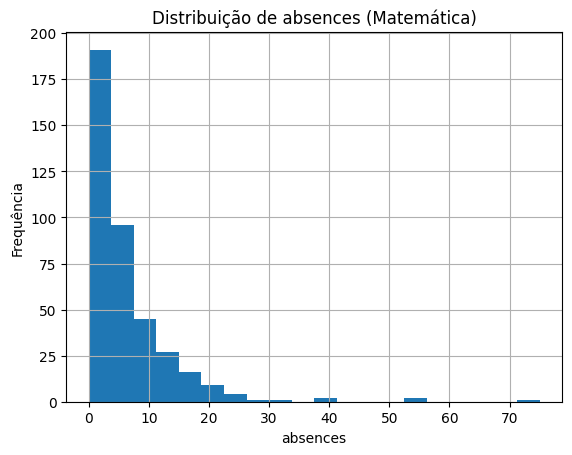

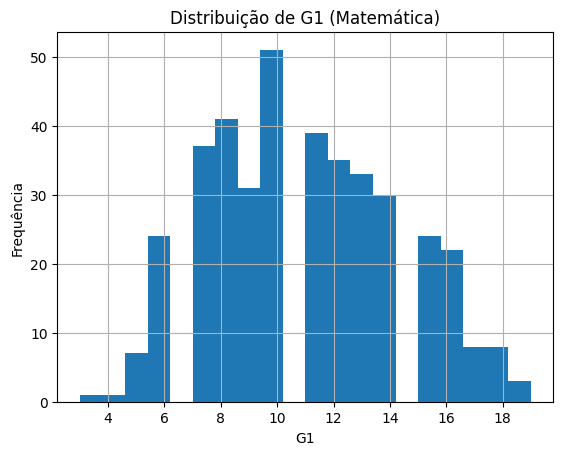

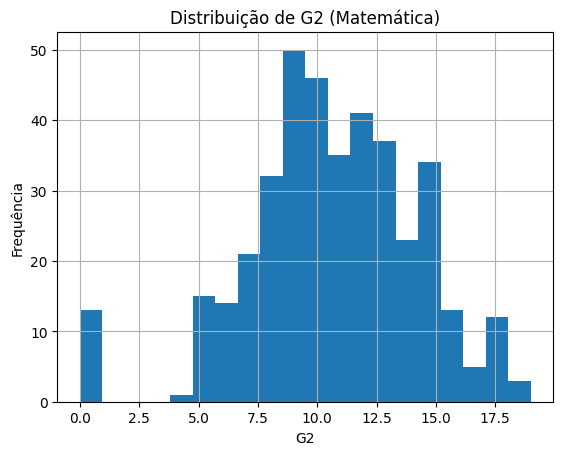

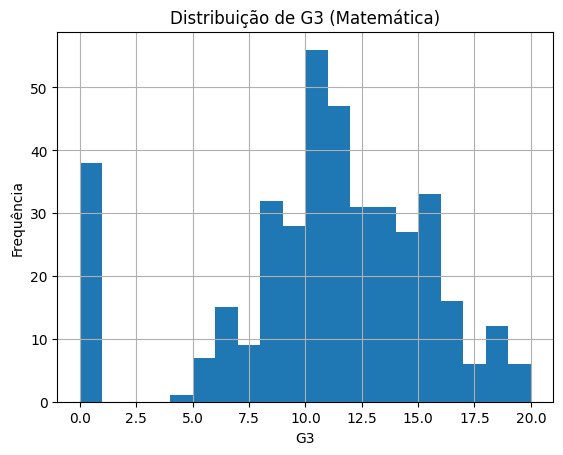


Correlação com G3:


,G3
G3,1.000000
G2,0.904868
G1,0.801468
Medu,0.217147
Fedu,0.152457
studytime,0.097820
famrel,0.051363
absences,0.034247
freetime,0.011307
Walc,-0.051939


In [ ]:

display(df.info())
display(df.isna().sum().sort_values(ascending=False).head(10))

cat_cols = [c for c in df.columns if df[c].dtype == 'object']
num_cols = [c for c in df.columns if df[c].dtype != 'object']

print("Categóricas:", len(cat_cols))
print("Numéricas  :", len(num_cols))

display(df.describe(include='all').transpose().head(25))

cands = [c for c in ["age","absences","G1","G2","G3","G3_mat","G3_por","G3_avg"] if c in df.columns]
for col in cands:
    plt.figure()
    df[col].hist(bins=20)
    plt.title(f"Distribuição de {col} ({base_label})")
    plt.xlabel(col)
    plt.ylabel("Frequência")
    plt.show()

targets = [c for c in ["G3","G3_mat","G3_por","G3_avg"] if c in df.columns]
for t in targets:
    cols = [c for c in num_cols if c != t] + [t]
    corr = df[cols].corr()
    print(f"\nCorrelação com {t}:")
    display(corr[t].sort_values(ascending=False).head(15))


## 3) Preparação e Modelagem

Resultados — Regressão


,Modelo,RMSE,MAE,R2
0,LinearRegression,2.378370,1.646666,0.724134
1,RandomForestRegressor,1.974733,1.170633,0.809824


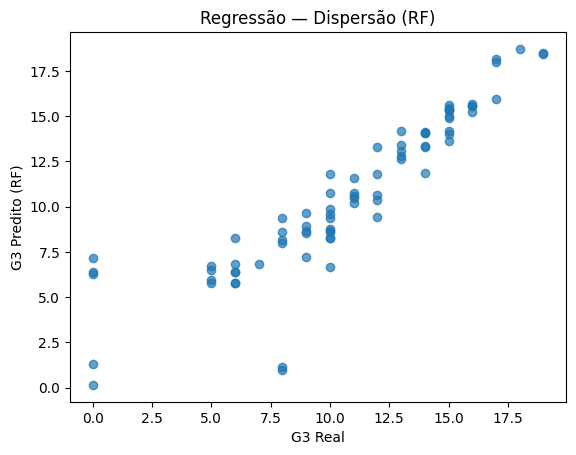

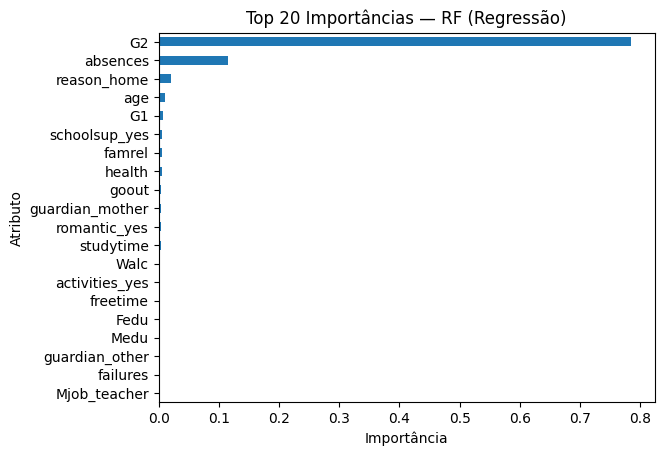

Resultados — Classificação


,Modelo,Accuracy,Precision,Recall,F1,ROC_AUC
0,LogisticRegression,0.898734,0.94,0.903846,0.921569,0.973647
1,RandomForestClassifier,0.898734,0.94,0.903846,0.921569,0.960470


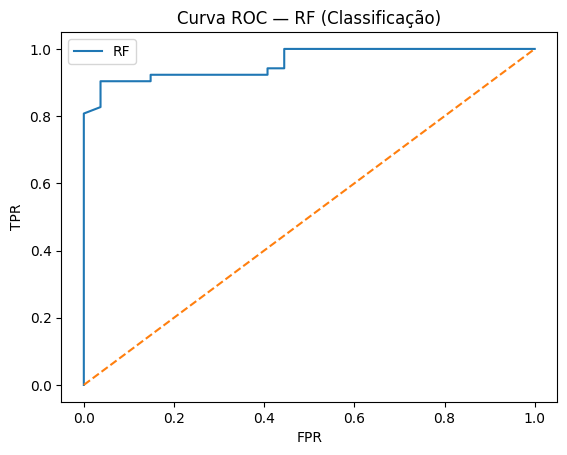

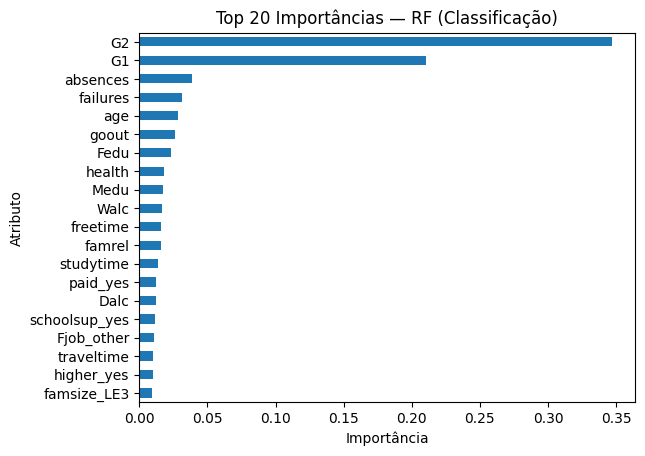

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define alvo de regressão conforme base
if "G3" in df.columns:
    target_reg = "G3"
elif "G3_avg" in df.columns:
    target_reg = "G3_avg"
elif "G3_mat" in df.columns:
    target_reg = "G3_mat"
else:
    target_reg = "G3_por"

df["passou"] = (df[target_reg] >= 10).astype(int)

# Features/Targets
X_reg = df.drop(columns=[target_reg, "passou"])
y_reg = df[target_reg]

X_cls = df.drop(columns=[target_reg, "passou"])
y_cls = df["passou"]

# One-hot
X_reg_enc = pd.get_dummies(X_reg, drop_first=True)
X_cls_enc = pd.get_dummies(X_cls, drop_first=True)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg_enc, y_reg, test_size=0.2, random_state=42)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cls_enc, y_cls, test_size=0.2, random_state=42)

# Regressão: Linear vs RF
scaler_r = StandardScaler(with_mean=False)
Xr_train_s = scaler_r.fit_transform(Xr_train)
Xr_test_s  = scaler_r.transform(Xr_test)

lin_reg = LinearRegression()
lin_reg.fit(Xr_train_s, yr_train)
yr_pred_lr = lin_reg.predict(Xr_test_s)

rf_reg = RandomForestRegressor(n_estimators=300, random_state=42)
rf_reg.fit(Xr_train, yr_train)
yr_pred_rf = rf_reg.predict(Xr_test)

def reg_metrics(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

m_lr = reg_metrics(yr_test, yr_pred_lr)
m_rf = reg_metrics(yr_test, yr_pred_rf)

res_reg = pd.DataFrame([
    {"Modelo":"LinearRegression", **m_lr},
    {"Modelo":"RandomForestRegressor", **m_rf},
])
print("Resultados — Regressão")
display(res_reg)

# Visual: Real vs Predito (RF)
plt.figure()
plt.scatter(yr_test, yr_pred_rf, alpha=0.7)
plt.xlabel(f"{target_reg} Real")
plt.ylabel(f"{target_reg} Predito (RF)")
plt.title("Regressão — Dispersão (RF)")
plt.show()

# Importâncias RF (Regressão)
imp_rf = pd.Series(rf_reg.feature_importances_, index=Xr_train.columns).sort_values(ascending=False).head(20)
plt.figure()
imp_rf[::-1].plot(kind='barh')
plt.title("Top 20 Importâncias — RF (Regressão)")
plt.xlabel("Importância")
plt.ylabel("Atributo")
plt.show()

# Classificação: Logistic vs RF
scaler_c = StandardScaler(with_mean=False)
Xc_train_s = scaler_c.fit_transform(Xc_train)
Xc_test_s  = scaler_c.transform(Xc_test)

log_clf = LogisticRegression(max_iter=200)
log_clf.fit(Xc_train_s, yc_train)
yc_pred_lr = log_clf.predict(Xc_test_s)
yc_proba_lr = log_clf.predict_proba(Xc_test_s)[:,1]

rf_clf = RandomForestClassifier(n_estimators=300, random_state=42)
rf_clf.fit(Xc_train, yc_train)
yc_pred_rf = rf_clf.predict(Xc_test)
yc_proba_rf = rf_clf.predict_proba(Xc_test)[:,1]

def cls_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_true, y_proba),
    }

m_lr_c = cls_metrics(yc_test, yc_pred_lr, yc_proba_lr)
m_rf_c = cls_metrics(yc_test, yc_pred_rf, yc_proba_rf)

res_cls = pd.DataFrame([
    {"Modelo":"LogisticRegression", **m_lr_c},
    {"Modelo":"RandomForestClassifier", **m_rf_c},
])
print("Resultados — Classificação")
display(res_cls)

# ROC (RF)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(yc_test, yc_proba_rf)
plt.figure()
plt.plot(fpr, tpr, label="RF")
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC — RF (Classificação)")
plt.legend()
plt.show()

# Importâncias RF (Classificação)
imp_rf_c = pd.Series(rf_clf.feature_importances_, index=Xc_train.columns).sort_values(ascending=False).head(20)
plt.figure()
imp_rf_c[::-1].plot(kind='barh')
plt.title("Top 20 Importâncias — RF (Classificação)")
plt.xlabel("Importância")
plt.ylabel("Atributo")
plt.show()

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=res_cls)

https://docs.google.com/spreadsheets/d/1Y6ZhSjaWxf5gigLcaF46vM9yMxZraJ9PHyfeKhthYao/edit#gid=0


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=res_reg)

https://docs.google.com/spreadsheets/d/1-2F0GLI9bfXr23jKCNcY2lPHc06uysn7jXh9Zh7QbT8/edit#gid=0



## 4) Próximos passos
- Validar com KFold/StratifiedKFold.
- Ajustar hiperparâmetros (GridSearchCV/RandomizedSearchCV).
- Verificar balanceamento da classe `passou`.
